In [6]:
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import os
from scipy import stats
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy.stats import gaussian_kde

In [11]:
#IDir = r'/Volumes/PhD/imagery/masters/output/dNBR/'
#ODir = r'/Volumes/PhD/imagery/masters/output/ROC/design_storm/'
IDir = r'/Volumes/PhD/imagery/masters/hyper/HSM1/'
ODir = r'/Volumes/PhD/imagery/masters/hyper/'
basin_path = r'/Volumes/PhD/imagery/masters/baer/thm2017_Basin_DFPredictions_15min_12mmh.shp'
basins_df = gpd.read_file(basin_path)
basin_id = basins_df['BASIN_ID']
basin_df = pd.DataFrame(basin_id)
basin_df

,BASIN_ID
0,123
1,155
2,167
3,172
4,184
...,...
1731,44218
1732,44238
1733,44256
1734,44320


In [5]:
def M1(dnbr, basin_data,
          save=False):
    
    # Coefficients for Southern California
    b = -3.63
    b_1 = 0.41
    b_2 = 0.67
    b_3 = 0.7
    

    results = []

    for basin_id, basin_row in basin_data.iterrrows():
        # File naming
        dnbr_flat = dnbr.values.flatten()
        pixarr = np.empty((dnbr_flat.shape[0]), dtype= float)
        pixarr[:] = np.nan
        x = np.where(np.isnan(dnbr_flat) == False)
            
        # Getting the data from dnbr_flat
        dnbrdata = dnbr_flat[x]
        dnbrdata = np.mean(dnbrdata)
            
        # Pulling tif metadata
        metadata = dnbr.attrs
        x_1 = float(metadata.get('X1'))
        x_3 = float(metadata.get('X3'))
        
        #R = basin_row['RI']
        R = [3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
        for RI in R:
            lnx =  b + (b_1 * x_1 * RI) + (b_2 * dnbrdata * RI) + (b_3 * x_3 * RI)
            prob = (e ** lnx) / (1.0 + e ** lnx)
            results.append({'BASIN_ID': basin_id, 'RI': RI*4, 'Probability': prob})
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
design_storm = M1()

In [12]:
def calculate_image_statistics(dnbr_dir, basin_data):
    # Ensure BASIN_ID is string to match filenames
    basin_data["BASIN_ID"] = basin_data["BASIN_ID"].astype(str)

    # Get a list of all files in the directory
    file_list = os.listdir(dnbr_dir)

    # Initialize lists to store the computed statistics
    mean_list = []
    median_list = []
    peak_frequency_list = []

    # Loop through each row in basin_data
    for index, row in basin_data.iterrows():
        basin_id = row["BASIN_ID"]

        # Construct the expected file name
        #file_name = f"basin_{basin_id}_dNBR.tif"
        file_name = f'{basin_id}_dNBR.tif'

        # Check if the file exists
        if file_name not in file_list:
            print(f"No matching file for Basin_ID: {basin_id}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)
            continue

        # Full path to the matching file
        file_path = os.path.join(dnbr_dir, file_name)

        try:
            # Open the raster file
            with rasterio.open(file_path) as src:
                dnbr_data = src.read(1)  # Read the first band
                dnbr_data = dnbr_data.astype(float)  # Ensure it's float for calculations
                
                # Replace nodata values with NaN
                dnbr_data[dnbr_data == src.nodata] = np.nan

                # Calculate statistics
                mean_value = np.nanmean(dnbr_data)
                median_value = np.nanmedian(dnbr_data)
                
                # Calculate peak frequency
                valid_data = dnbr_data[~np.isnan(dnbr_data)]  # Remove NaNs
                rounded_data = np.round(valid_data, 4)
                #peak_frequency = statistics.mode(rounded_data)
                
                kde = gaussian_kde(valid_data)

                # Define a grid of values for evaluation
                x_grid = np.linspace(valid_data.min(), valid_data.max(), 1000)

                # Evaluate KDE on the grid
                kde_values = kde(x_grid)

                # Find the peak value
                peak_index = kde_values.argmax()  # Index of the maximum KDE value
                peak_frequency = x_grid[peak_index]

                # Append statistics to lists
                mean_list.append(mean_value)
                median_list.append(median_value)
                peak_frequency_list.append(peak_frequency)

        except Exception as e:
            print(f"Error processing Basin_ID {basin_id}: {e}")
            mean_list.append(np.nan)
            median_list.append(np.nan)
            peak_frequency_list.append(np.nan)

    # Add the calculated statistics to basin_data
    basin_data["Mean_dNBR"] = mean_list
    basin_data["Med_dNBR"] = median_list
    basin_data["PF_dNBR"] = peak_frequency_list

    return basin_data

In [14]:
x_df = calculate_image_statistics(IDir, basin_df)
x_df.dropna()
x_df


No matching file for Basin_ID: 123
No matching file for Basin_ID: 155
No matching file for Basin_ID: 167
No matching file for Basin_ID: 172
No matching file for Basin_ID: 184
No matching file for Basin_ID: 190
No matching file for Basin_ID: 218
No matching file for Basin_ID: 232
No matching file for Basin_ID: 256
No matching file for Basin_ID: 275
No matching file for Basin_ID: 308
No matching file for Basin_ID: 315
No matching file for Basin_ID: 335
No matching file for Basin_ID: 390
No matching file for Basin_ID: 409
No matching file for Basin_ID: 579
No matching file for Basin_ID: 937
No matching file for Basin_ID: 939
No matching file for Basin_ID: 969
No matching file for Basin_ID: 1057
No matching file for Basin_ID: 1062
No matching file for Basin_ID: 1117
No matching file for Basin_ID: 1128
No matching file for Basin_ID: 1130
No matching file for Basin_ID: 1136
No matching file for Basin_ID: 1140
No matching file for Basin_ID: 1174
No matching file for Basin_ID: 1189
No matching

,BASIN_ID,Mean_dNBR,Med_dNBR,PF_dNBR
0,123,NaN,NaN,NaN
1,155,NaN,NaN,NaN
2,167,NaN,NaN,NaN
3,172,NaN,NaN,NaN
4,184,NaN,NaN,NaN
...,...,...,...,...
1731,44218,NaN,NaN,NaN
1732,44238,NaN,NaN,NaN
1733,44256,NaN,NaN,NaN
1734,44320,NaN,NaN,NaN


In [28]:
basins = ['17346', '19384', '19451', '21224']
basin = x_df[x_df['BASIN_ID'].isin(basins)]
basin.to_csv(os.path.join(ODir, 'basins.csv'))

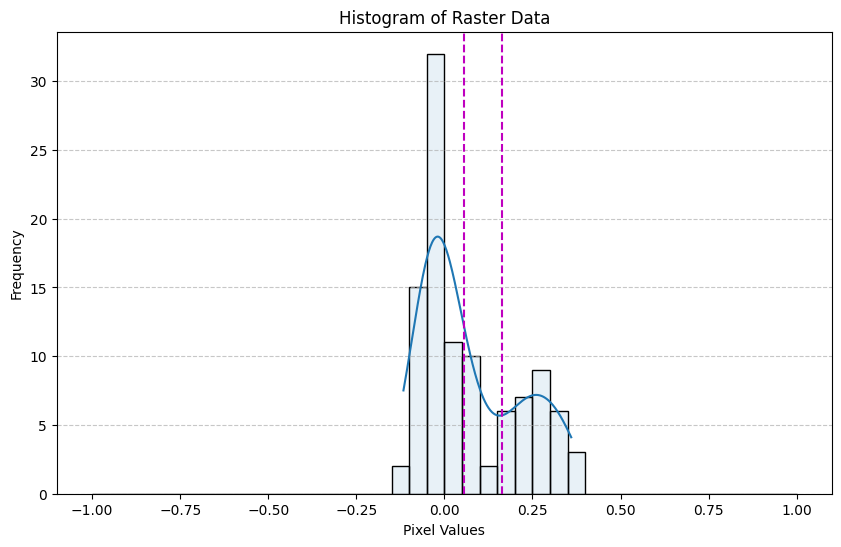

In [9]:
dnbr_c = r'/Volumes/PhD/imagery/masters/output/dNBR/basin_3115_dNBR.tif'
dnbr_c = rxr.open_rasterio(dnbr_c)
dnbr_array = dnbr_c.values

# Flatten the array and remove NaN values
valid_data = dnbr_array.flatten()
valid_data = valid_data[~np.isnan(valid_data)]

# Plot the histogram
bin = np.arange(-1, 1.05, 0.05)
plt.figure(figsize=(10, 6))
sns.histplot(valid_data, bins=bin, kde=True, alpha=.1)
plt.axvline(x=.055359, color='m', linestyle='--')
plt.axvline(x=.164376, color='m', linestyle='--')

#plt.hist(valid_data, bins=bin, color='blue', alpha=0.7, edgecolor='black')  # Adjust bins as needed
plt.title("Histogram of Raster Data")
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
x_df['BASIN_ID'] = x_df['BASIN_ID'].astype(int)
print(x_df)
merged_gdf = gpd.GeoDataFrame(
    pd.merge(basins_df, x_df, on="BASIN_ID", how="left")
)

# Check the result
print(merged_gdf['PF_dNBR'])

      BASIN_ID  Mean_dNBR  Med_dNBR   PF_dNBR
0          123   0.135826  0.068758  0.042093
1          155   0.260572  0.151689  0.063711
2          167   0.317980  0.271129  0.140899
3          172   0.362372  0.296424  0.126700
4          184   0.567295  0.592624  0.610778
...        ...        ...       ...       ...
1731     44218   0.109455  0.073427  0.030402
1732     44238   0.176968  0.177423  0.186665
1733     44256   0.289667  0.279276  0.260739
1734     44320   0.542320  0.526273  0.466265
1735     44339   0.360893  0.364678  0.378696

[1736 rows x 4 columns]
0       0.042093
1       0.063711
2       0.140899
3       0.126700
4       0.610778
          ...   
1731    0.030402
1732    0.186665
1733    0.260739
1734    0.466265
1735    0.378696
Name: PF_dNBR, Length: 1736, dtype: float64


In [14]:
merged_gdf.to_file(os.path.join(ODir + 'M1_design_storm.shp'))